AI Programming - SW Lee

# Lab 03: Optimizers for Deep Neural Networks
## Exercise: Predicting MNIST Digits
### For this exercise, prepare privious Lab to copy your previous implementations.

### Prepare Mini-MNIST Dataset

In [182]:
import numpy as np # 행렬 연산 라이브러리
from sklearn.datasets import load_digits # 손글씨 데이터셋
from sklearn.model_selection import train_test_split # 데이터셋 분리
from sklearn.preprocessing import StandardScaler # 데이터 전처리
import matplotlib.pyplot as plt # 그래프 라이브러리

In [183]:
digits = load_digits() # 손글씨 데이터셋 로드

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1)) # 8x8 픽셀 이미지를 64개의 픽셀로 변환
digits_tf = digits.target # 손글씨 데이터셋의 정답

# Splitting dataframe into train & test
# 80% train, 20% test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16

# StandarScaler는 각 feature의 평균을 0, 분산을 1로 변경하여 모든 feature들이 같은 scale을 갖도록 만들어줍니다.
sc = StandardScaler() 
X_train = sc.fit_transform(X_train_org) # fit_transform은 fit과 transform을 동시에 수행하는 함수입니다. fit은 데이터의 평균과 분산을 구하는 역할을 합니다.
X_test = sc.transform(X_test_org) # transform은 fit에서 설정된 값으로 데이터를 변환합니다.

n_classes = 10 # 0~9까지 총 10개의 클래스가 있습니다.

# Transform Nx1 Y vector into Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10)) # 0으로 채워진 2차원 배열을 생성합니다.
for i in range(n_classes): # 0~9까지 반복합니다.
    y_train[:,i] = (y_train_num == i) # y_train_num이 i와 같으면 1로 채웁니다.

Define Utility Functions

In [184]:
from tensorflow.math import sigmoid as tf_sigmoid # tensorflow의 sigmoid 함수를 불러옵니다.
from tensorflow.nn import softmax as tf_softmax # tensorflow의 softmax 함수를 불러옵니다.

def sigmoid(x): # sigmoid 함수를 정의합니다.
    x = tf_sigmoid(x) # tensorflow의 sigmoid 함수를 사용합니다.
    return x.numpy() # numpy 배열로 변환하여 반환합니다.

def softmax(x): # softmax 함수를 정의합니다.
    x = tf_softmax(x) # tensorflow의 softmax 함수를 사용합니다.
    return x.numpy() # numpy 배열로 변환하여 반환합니다.

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


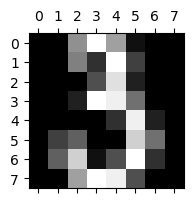

The number is 3


In [185]:
print(digits_df.shape) # 손글씨 데이터셋의 shape를 출력합니다.
print(X_train.shape) # X_train의 shape를 출력합니다.
print(y_train.shape) # y_train의 shape를 출력합니다.
print(X_train_org[0]) # X_train_org의 첫번째 데이터를 출력합니다.

idx = np.random.randint(X_train.shape[0]) # 0부터 X_train의 크기까지 랜덤한 정수를 생성합니다.
dimage = X_train_org[idx].reshape((8,8)) # X_train_org의 idx번째 데이터를 8x8로 변환합니다.
plt.figure(figsize=(2,2)) # 그래프의 크기를 설정합니다.
plt.gray() # 그래프의 색상을 흑백으로 설정합니다.
plt.matshow(dimage, fignum=1) # 이미지를 출력합니다.
plt.show() # 그래프를 출력합니다.
print('The number is', y_train_num[idx]) # idx번째 데이터의 정답을 출력합니다.


### Simple DNN for Digit Classification

Define Model Class

In [186]:
class myDenseLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.empty((n_out, n_in)) # n_out x n_in 크기의 빈 행렬을 생성합니다.
        self.bias = np.zeros((n_out)) # n_out 크기의 0으로 채워진 행렬을 생성합니다.
        self.saved_x = None     # store x to use while backpropagation

    def forward(self, x):       # (b, i)
        ### START CODE HERE ###
        self.saved_x = x     # keep it for backward
        x_lin = (self.wegt @ x.T).T + self.bias   # Linear Prediction
        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        assert np.array_equal(self.saved_x, x_in), print('x_in does not equal to input X.')
        ### START CODE HERE ###
        
        # 가중치에 대한 기울기 계산 (차원에 맞추어 연산)
        dw = x.T @ x_in  # @ 연산자를 사용하여 행렬 곱셈 (x.T의 shape과 x_in의 shape에 맞춰 연산)
        # 편향에 대한 기울기 계산
        db = np.sum(x, axis=0)  # 각 출력에 대한 편향의 기울기
        # 이전 레이어로 전달할 기울기 계산
        wdJdz = x @ self.wegt  # wegt는 가중치, x는 현재 레이어의 출력, @ 연산자로 행렬 곱셈
        ### END CODE HERE ###
        return dw, db, wdJdz # return dJ/dw, dJ/db, dJ/dx


Define Backpropagation of Activation Functions

In [187]:
# sigmoid 함수의 기울기를 계산하는 함수를 구현합니다.
def dJdz_sigmoid(wdJdz_upper, az):
    ### START CODE HERE ###

    dJdz = wdJdz_upper * az * (1 - az)            # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz # dJ/dz 반환

# softmax 함수의 기울기를 계산하는 함수를 구현합니다.
def dJdz_softmax(y_hat, y):
    ### START CODE HERE ###
    
    dJdz = y_hat - y            # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz # dJ/dz 반환

Define Training Functions

In [188]:
# 3개의 layer에 대한 forward, backward, loss, predict 함수를 구현합니다.
def my_forward(layers, X_in): 
    # layers = [l1, l2, l3]
    l1, l2, l3 = layers
    ### START CODE HERE ###

    # forward pass
    a_1 = sigmoid(l1.forward(X_in))               # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward

    ### END CODE HERE ###
    return a_1, a_2, a_3 # return a_1, a_2, a_3

# 3개의 layer에 대한 forward, backward, loss, predict 함수를 구현합니다.
def my_backward(layers, a_1, a_2, a_3, X_in, y_true):
    l1, l2, l3 = layers # layers = [l1, l2, l3]
    ### START CODE HERE ###

    # backward pass
    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3, y_true) , a_2)    # go through 3rd stage backward
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_sigmoid(wdJdz_3, a_2), a_1)    # go through 2nd stage backward
    dw_1, db_1, _       = l1.backward(dJdz_sigmoid(wdJdz_2, a_1)  , X_in)    # go through 1st stage backward

    ### END CODE HERE ###
    d_1 = [dw_1, db_1] # d_1 = [dJ/dw_1, dJ/db_1]
    d_2 = [dw_2, db_2] # d_2 = [dJ/dw_2, dJ/db_2]
    d_3 = [dw_3, db_3] # d_3 = [dJ/dw_3, dJ/db_3]
    return d_1, d_2, d_3 

def my_loss(layers, X_in, y_true):
    l1, l2, l3 = layers # layers = [l1, l2, l3]
    ### START CODE HERE ###

    # forward pass
    a_1 = sigmoid(l1.forward(X_in))               # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward
    # calculate loss
    # clip 함수를 사용하여 a_3의 값이 0이 되는 것과 1초과하는 것을 방지합니다.
    # if np.any((a_3 <= 0) | (a_3 >= 1)):
    #     print("a_3 out of range: ")
    #     print(a_3)
    loss = -np.sum(y_true * np.log(np.clip(a_3, 1e-9, 1))) / y_true.shape[0] # y_true와 a_3는 동일한 shape이어야 함         # calculate loss

    ### END CODE HERE ###
    return loss
    
def my_predict(layers, X_in):
    l1, l2, l3 = layers
    ### START CODE HERE ###

    # forward pass
    a_1 = sigmoid(l1.forward(X_in))               # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward
    
    # predict
    # a_3의 마지막 차원을 기준으로 가장 큰 값의 인덱스를 반환
    pred = np.argmax([a_3], axis=-1).reshape(-1) 
    ### END CODE HERE ###
    return pred

Create a NN model and check the matrix dimensions

In [189]:
n_inputs  = 64  # 8x8 픽셀 이미지를 1차원으로 변환하면 64개의 입력
n_hidden1 = 80 # 첫번째 은닉층의 노드 수
n_hidden2 = 70 # 두번째 은닉층의 노드 수
n_classes = 10 # 0~9까지 총 10개의 클래스

l1 = myDenseLayer(n_hidden1, n_inputs) # 첫번째 은닉층
l2 = myDenseLayer(n_hidden2, n_hidden1) # 두번째 은닉층
l3 = myDenseLayer(n_classes, n_hidden2) # 출력층

layers = [l1, l2, l3] # 3개의 layer를 리스트로 저장

print(X_train.shape, y_train.shape) # X_train과 y_train의 shape를 출력
print(l1.wegt.shape, l1.bias.shape) # l1의 가중치와 편향의 shape를 출력
print(l2.wegt.shape, l2.bias.shape) # l2의 가중치와 편향의 shape를 출력
print(l3.wegt.shape, l3.bias.shape) # l3의 가중치와 편향의 shape를 출력

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


Weight Initialization

In [190]:
# Weights are initialized to...
l1.wegt = np.random.randn(n_hidden1, n_inputs) # l1의 가중치를 랜덤한 값으로 초기화합니다.
l2.wegt = np.random.randn(n_hidden2, n_hidden1) # l2의 가중치를 랜덤한 값으로 초기화합니다.
l3.wegt = np.random.randn(n_classes, n_hidden2) # l3의 가중치를 랜덤한 값으로 초기화합니다.

Define a Function for Splitting Dataset into mini-Batches

In [191]:
def create_mini_batches(X, y, batch_size=64): # 미니배치를 생성하는 함수를 구현합니다.
    mini_batches = [] # 미니배치를 저장할 리스트
    n_minibatches = (X.shape[0] // batch_size) # mini-batch의 개수
    n_variables = X.shape[1] # feature의 개수
    ### START CODE HERE ###

    data = np.hstack((X, y))           # concatenate X and y with np.hstack
    np.random.shuffle(data)      # then shuffle it
    
    # create mini-batches
    # mini-batch의 개수만큼 반복하면서 mini-batch를 생성합니다.
    for i in range(n_minibatches):
        mini_batch = data[ (i * batch_size):((i+1) * batch_size)  , :  ]        # get a slice of mini-batch
        X_mini, y_mini = mini_batch[:, :n_variables], mini_batch[:, n_variables:]   # split mini-batch into X & y
        mini_batches.append((X_mini, y_mini)) # mini-batch를 리스트에 추가합니다.
    
    # 만약 남은 데이터가 있다면 마지막 mini-batch를 생성합니다.
    if data.shape[0] % batch_size != 0:
        mini_batch = data[n_minibatches*batch_size : , : ]        # process the remaining data
        X_mini, y_mini = mini_batch[:, :n_variables], mini_batch[:, n_variables:]    # split mini-batch into X & y
        mini_batches.append((X_mini, y_mini)) # mini-batch를 리스트에 추가합니다.

    ### END CODE HERE ###
    return mini_batches

In [192]:
np.random.seed(1)  # 랜덤 시드를 설정합니다.

a = np.arange(20).reshape(10,2) # 0~19까지의 숫자를 10x2 행렬로 생성합니다.
b = -np.arange(10,20).reshape(10,1) # 10~19까지의 숫자를 10x1 행렬로 생성합니다.

# 미니 배치를 생성합니다.
c = create_mini_batches(a, b, 4)
# 미니 배치를 출력하고 확인합니다.
for mini_X, mini_y in c: # mini_X와 mini_y를 출력합니다.
    print(mini_X)   # mini_X를 출력합니다.
    print(mini_y, '\n') # mini_y를 출력합니다.


[[ 4  5]
 [18 19]
 [12 13]
 [ 8  9]]
[[-12]
 [-19]
 [-16]
 [-14]] 

[[ 0  1]
 [ 6  7]
 [ 2  3]
 [14 15]]
[[-10]
 [-13]
 [-11]
 [-17]] 

[[16 17]
 [10 11]]
[[-18]
 [-15]] 



expected outpu:
```
[[ 4  5]          [[ 0  1]           [[16 17] 
 [18 19]           [ 6  7]            [10 11]] 
 [12 13]           [ 2  3]           [[-18] 
 [ 8  9]]          [14 15]]           [-15]]  
[[-12]            [[-10]             
 [-19]             [-13]             
 [-16]             [-11]             
 [-14]]            [-17]]              
```

## Define Various Optimizers

Stochastic Gradient $$ g_t = \nabla J(W_t,x^{(i)},y^{(i)}), \;\text{for mini-batch}\; (i) \to (i:i+n) $$

SGD with momentum $$ \Delta W(t) = \gamma \Delta W (t-1) + \alpha \cdot g_t $$
AdaGrad $$ \Delta W(t) = {\eta {1 \over \sqrt{\delta_t + \epsilon}}} \odot g_t, \;\text{where}\; \delta_t = \delta_{t-1} + g_t^2 $$
RMSProp $$ \Delta W(t) = {\eta {1 \over \sqrt{\delta_t + \epsilon}}} \odot g_t, \;\text{where}\; \delta_t = \beta \delta_{t-1} + (1-\beta) g_t^2 $$
Adam $$ \Delta W(t) = {\eta {\hat{m}_t \over \sqrt{\hat{v}_t} + \epsilon}} \odot g_t, \;\text{where}\; \hat{m}_t = {m_t \over {1 - \beta_1^t}}, \; \hat{v}_t = {v_t \over {1 - \beta_2^t}}, $$
$$ \text{and}\; m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t, \; v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $$


In this experiment mini-batch gradient is used for all optimization methods unless mentioned otherwise.<br>
Investigate and discuss the effect on convergence of each optimizer

In [193]:
class myOptParam:
    def __init__(self, n_out, n_in):
        # Previoud delta values for momentum optimizer
        self.W_dt = np.zeros((n_out, n_in)) # n_out x n_in 크기의 0으로 채워진 행렬을 생성한다. 
        self.B_dt = np.zeros(n_out) # n_out 크기의 0으로 채워진 행렬을 생성한다.
        # Variables for other optimizers 
        self.W_mt = np.zeros((n_out, n_in)) # n_out x n_in 크기의 0으로 채워진 행렬을 생성한다.
        self.B_mt = np.zeros(n_out) # n_out 크기의 0으로 채워진 행렬을 생성한다.
        self.W_vt = np.zeros((n_out, n_in)) # n_out x n_in 크기의 0으로 채워진 행렬을 생성한다.
        self.B_vt = np.zeros(n_out) # n_out 크기의 0으로 채워진 행렬을 생성한다.

# optimizer를 구현합니다.
def my_optimizer(lyr, opt, W_grad, B_grad, solver='sgd', learning_rate=0.01, iter=1):
    epsilon = 1e-8  # arbitrary small number
    alpha = eta = learning_rate # learning rate

    if iter==0:
        print('iteration should start from 1.')

    # optimizer routines
    if  solver=='sgd':
        W_dlt = alpha * W_grad # delta for weight
        B_dlt = alpha * B_grad # delta for bias
    elif solver=='momentum':
        gamma = 0.9               # default setting
        ### START CODE HERE ###
        
        W_dlt = gamma * opt.W_dt + alpha * W_grad              # momentum for previous delta
        B_dlt = gamma * opt.B_dt + alpha * B_grad              # same goes for bias
        opt.W_dt = W_dlt           # keep data for later use
        opt.B_dt = B_dlt          # for bias, too

        ### END CODE HERE ###
    elif solver=='adagrad':
        ### START CODE HERE ###

        opt.W_vt += W_grad**2            # accumulate delta square (2nd momentum)
        opt.B_vt += B_grad**2           # accumulater for bias term
        W_dlt = (alpha / np.sqrt(opt.W_vt + epsilon)) * W_grad              # calculate new delta for weight
        B_dlt = (alpha / np.sqrt(opt.B_vt + epsilon)) * B_grad              # and for bias

        ### END CODE HERE ###
    elif solver=='rmsprop':
        beta2 = 0.9               # default setting
        ### START CODE HERE ###

        opt.W_vt = beta2 * opt.W_vt + (1-beta2) * (W_grad**2)            # blending with second momentum
        opt.B_vt = beta2 * opt.B_vt + (1-beta2) * (B_grad**2)            # also doging samething for bias
        W_dlt = alpha / (np.sqrt(opt.W_vt + epsilon)) * W_grad              # calculate new delta for weight
        B_dlt = alpha / (np.sqrt(opt.B_vt + epsilon)) * B_grad              # and for bias
        
        ### END CODE HERE ###
    elif solver=='adam':
        beta1, beta2 = 0.9, 0.99  # default setting beta1, beta2 = 0.9, 0.99
        ### START CODE HERE ###

        opt.W_mt = beta1 * opt.W_mt + (1 - beta1) * W_grad          # blending with first momentum
        opt.B_mt = beta1 * opt.B_mt + (1 - beta1) * B_grad          # first momentum for bias
        opt.W_vt = beta2 * opt.W_vt + (1 - beta2) * (W_grad ** 2)     # blending with second momentum
        opt.B_vt = beta2 * opt.B_vt + (1 - beta2) * (B_grad ** 2)     # second momentum for bias

        # Bias corrections
        W_mc = opt.W_mt / (1 - beta1 ** iter)   # bias correction of first momentum for weight
        B_mc = opt.B_mt / (1 - beta1 ** iter)   # and for bias term
        W_vc = opt.W_vt / (1 - beta2 ** iter)   # bias correction of second momentum for weight
        B_vc = opt.B_vt / (1 - beta2 ** iter)   # and for bias term

        W_dlt = alpha * W_mc / (np.sqrt(W_vc) + epsilon)    # calculate new delta for weight
        B_dlt = alpha * B_mc / (np.sqrt(B_vc) + epsilon)    # and for bias

    
        ### END CODE HERE ###
    else:  
        print('optimizer error')

    # Adjust weight
    lyr.wegt = lyr.wegt - W_dlt
    lyr.bias = lyr.bias - B_dlt

    return

Optimizer Test

In [194]:
np.random.seed(101)

lyr = myDenseLayer(2,3)
opt = myOptParam(2,3)

lyr.wegt = np.random.randn(2,3)
lyr.bias = np.random.randn(2)
opt.W_dt = np.random.randn(2,3)
opt.B_dt = np.random.randn(2)
opt.W_mt = np.random.randn(2,3)
opt.B_mt = np.random.randn(2)
opt.W_vt = np.abs(np.random.randn(2,3))
opt.B_vt = np.abs(np.random.randn(2))

W_grad = np.random.randn(2,3)
B_grad = np.random.randn(2)

# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
opts = ['sgd', 'momentum', 'adagrad', 'rmsprop', 'adam']
expt = [[ 7.67789007,  8.16882972, 10.34203348, -3.22934657],
        [14.46528172,  15.04341688, 19.30016537, -4.77070266],
        [22.50872929,  22.74302212, 28.47667875, -7.62607443],
        [30.69802889,  30.60433129, 37.72651766, -10.62235939],
        [29.41774022,  19.27573813, 23.68071186,  1.52919472]]
test_passed = True # 테스트 결과를 저장할 변수

for i, sol in enumerate(opts):  # 5개의 optimizer에 대해 반복합니다.
    my_optimizer(lyr, opt, W_grad, B_grad, sol, 10, 3) # optimizer를 실행합니다.
    print('For '+sol+':') # optimizer 이름을 출력합니다.
    res = np.concatenate((lyr.wegt[0], lyr.bias[0:1]), axis=0) # 가중치와 편향을 합쳐서 출력합니다.
    print(res) # 결과를 출력합니다.

    if not np.allclose(res, expt[i]):  # 예상 결과와 다르다면
        print(sol+' failed.') # 실패 메시지를 출력합니다.
        test_passed = False # 테스트 결과를 False로 변경합니다.
if test_passed: print('test passed.') # 만약 모든 테스트가 통과했다면 성공 메시지를 출력합니다.
else: print('test failed.') # 테스트가 실패했다면 실패 메시지를 출력합니다.

For sgd:
[ 7.67789007  8.16882972 10.34203348 -3.22934657]
For momentum:
[14.46528172 15.04341688 19.30016537 -4.77070266]
For adagrad:
[22.50872929 22.74302212 28.47667875 -7.62607443]
For rmsprop:
[ 30.69802889  30.60433129  37.72651766 -10.62235939]
For adam:
[29.41774022 19.27573813 23.68071186  1.52919472]
test passed.


**Expected Outputs**

For SGD:
```
[ 7.67789007  8.16882972 10.34203348 -3.22934657]
```
For Momentum:
```
[14.46528172 15.04341688 19.30016537 -4.77070266]
```
Fpr Adagrad:
```
[22.50872929 22.74302212 28.47667875 -7.62607443]
```
For RMSProp:
```
[ 30.69802889  30.60433129  37.72651766 -10.62235939]
```
For Adam:
```
[29.41774022 19.27573813 23.68071186  1.52919472]
```

Create Optimizer Parameters

In [195]:
o1 = myOptParam(n_hidden1, n_inputs) # 첫번째 은닉층의 optimizer
o2 = myOptParam(n_hidden2, n_hidden1) # 두번째 은닉층의 optimizer
o3 = myOptParam(n_classes, n_hidden2) # 출력층의 optimizer

Training Simple Neural Network Model (3 layer model)

In [196]:
# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
# alpha is learning rate
optimizer ='sgd' # optimizer를 설정합니다.
alpha = 0.01 # learning rate를 설정합니다.
n_epochs = 1000 # epoch 수를 설정합니다.

for epoch in range(n_epochs):
    # create mini-batches
    batches = create_mini_batches(X_train, y_train, batch_size=64)
    # mini-batch를 반복하면서 학습을 진행합니다.
    for one_batch in batches:
        # mini-batch에서 X와 y를 가져옵니다.
        X_mini, y_mini = one_batch
        batch_len = X_mini.shape[0]  # last batch might have different length

        # Forward Path
        a_1, a_2, a_3 = my_forward(layers, X_mini)
        
        # Backward Path
        d_1, d_2, d_3 = my_backward(layers, a_1, a_2, a_3, X_mini, y_mini)

        dw_1, db_1 = d_1
        dw_2, db_2 = d_2
        dw_3, db_3 = d_3
        
        # Update weights and biases
        my_optimizer(l1, o1, dw_1, db_1, solver=optimizer, learning_rate=alpha, iter=epoch+1) # optimizer를 실행합니다. 
        my_optimizer(l2, o2, dw_2, db_2, solver=optimizer, learning_rate=alpha, iter=epoch+1) # optimizer를 실행합니다.
        my_optimizer(l3, o3, dw_3, db_3, solver=optimizer, learning_rate=alpha, iter=epoch+1) # optimizer를 실행합니다.

    # 100번째 epoch마다 loss를 출력합니다.
    if ((epoch+1)%100==0): 
        loss_J = my_loss(layers, X_train, y_train) # loss를 계산합니다.
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J)) # epoch와 loss를 출력합니다.

Epoch:  100,  loss: 0.00498634
Epoch:  200,  loss: 0.00224317
Epoch:  300,  loss: 0.00142530
Epoch:  400,  loss: 0.00103584
Epoch:  500,  loss: 0.00080901
Epoch:  600,  loss: 0.00066159
Epoch:  700,  loss: 0.00055858
Epoch:  800,  loss: 0.00048267
Epoch:  900,  loss: 0.00042447
Epoch: 1000,  loss: 0.00037846


Evaluate Model Performance

In [197]:
from sklearn.metrics import accuracy_score

# 학습 데이터에 대한 예측을 수행합니다.
y_pred = my_predict(layers, X_test)

# 정확도를 계산합니다.
accuracy_score(y_pred, y_test)

0.9527777777777777

Neural Network from scikit-learn

In [198]:
from sklearn.neural_network import MLPClassifier  # 다층 퍼셉트론(MLP)을 구현하는 클래스

mlp = MLPClassifier(
    hidden_layer_sizes=(80, 70, ),  # 은닉층의 크기를 정의. 여기서는 2개의 은닉층을 사용하며, 첫 번째 은닉층에는 80개의 뉴런, 두 번째 은닉층에는 70개의 뉴런을 사용
    activation='logistic',          # 활성화 함수로 'logistic' 함수를 사용 (로지스틱 시그모이드 함수).
    solver='sgd',                   # 최적화 알고리즘으로 확률적 경사 하강법(SGD)을 사용.
    alpha=0.01,                     # 학습률에 곱해지는 상수. 학습률을 조절하는 하이퍼파라미터
    learning_rate_init=0.01,        # 경사 하강법에서 가중치 업데이트의 크기를 결정
    max_iter=1000,                   # 최대 반복 횟수. 모델 학습 시 최대 1000번의 반복까지 수행. 이 횟수에 도달하면 학습이 멈춤
)
# Training/Fitting the Model
mlp.fit(X_train, y_train_num) # 학습 데이터에 대해 모델 학습

# Making Predictions
s_pred = mlp.predict(X_test) # 테스트 데이터에 대한 예측값 출력
accuracy_score(s_pred, y_test) # 정확도 출력

0.9777777777777777

### Test Model with a random sample


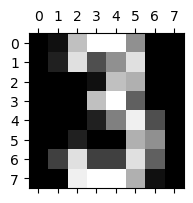

My prediction is 3
sk prediction is 3
Actual number is 3


In [199]:
idx = np.random.randint(X_test.shape[0]) # 0부터 X_test의 크기까지 랜덤한 정수를 생성합니다.
dimage = X_test_org[idx].reshape((8,8)) # X_test_org의 idx번째 데이터를 8x8로 변환합니다.
plt.figure(figsize=(2,2)) # 그래프의 크기를 설정합니다.
plt.gray() # 그래프의 색상을 흑백으로 설정합니다.
plt.matshow(dimage, fignum=1) # 이미지를 출력합니다.
plt.show() # 그래프를 출력합니다.

X_input = np.expand_dims(X_test[idx], 0) # X_test의 idx번째 데이터를 2차원으로 변환합니다.

y_pred = my_predict(layers, X_input) # 내 모델을 사용하여 예측합니다.

s_pred = mlp.predict(X_input) # sklean 모델을 사용하여 예측합니다.

print('My prediction is ' + str(y_pred[0])) # 내 모델의 예측을 출력합니다.
print('sk prediction is ' + str(s_pred[0])) # sklearn 모델의 예측을 출력합니다.
print('Actual number is ' + str(y_test[idx])) # 실제 정답을 출력합니다.


(c) 2024 SW Lee